# Exploring Stochastic Computing

## Introduction

[Stochastic computing](https://en.wikipedia.org/wiki/Stochastic_computing) (SC) encodes numbers as probabilities within streams of bits, enabling complex operations through simple logic gates like AND gates and multiplexers. SC was first conceptualized by John von Neumann in the 1950s and advanced by Gaines and Poppelbaum in the 1960s. The first (and last) International Symposium on Stochastic Computing took place in 1978.

## Fundamentals of Stochastic Computing

SC encodes numbers in bit-streams where the probability of a '1' denotes value. Basic operations use simple logic: AND gates for multiplication and multiplexers for scaled addition. The simplicity of (some) basic operations like multiplication was the main motivation behind stochastic computing. 

## Challenges in Stochastic Computing

1. **Precision vs. Bit-Stream Length:** Higher accuracy demands exponentially longer bit-streams
2. **Correlation Errors:** Correlated patterns in inputs can introduce significant errors (up to complete invalidation of computation)
3. **Conversion Overhead:** Converters from binary to stochastic formats are complex and negate the gate advantage

## References

[1] Yadu Kiran, Marc Riedel. "A Scalable Approach to Performing Multiplication and Matrix Dot-Products in Unary." (2023) https://arxiv.org/abs/2307.03204

[2] Armin Alaghi, Weikang Qian, John P. Hayes. "The Promise and Challenge of Stochastic Computing." IEEE Transactions on Computer-Aided Design (2018) https://ieeexplore.ieee.org/document/8122049

[3] Romisa Akhtar, Farooq A. Khanday. "Stochastic Computing: Systems, Applications, Challenges and Solutions." ICCES 2018. https://ieeexplore.ieee.org/document/8723960

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from scipy.stats.qmc import Halton

In [45]:
def generate_random_bits(p: float, q: float, N: int, seed: int = 42):
    # Set random seed for reproducibility
    rnd = np.random.RandomState(seed)

    # Generate random bit streams for inputs
    bits1 = (rnd.rand(N) < p).astype(int)
    bits2 = (rnd.rand(N) < q).astype(int)
    # Compute output via bitwise AND (i.e. multiplication for 0/1 bits)
    bits_out = bits1 * bits2

    return bits1, bits2, bits_out

def generate_halton_seq_bits(p: float, q: float, N: int, seed: int = 42):
    # Initialize Halton sequence generators for bits1 and bits2
    halton1 = Halton(d=1, seed=seed)
    halton2 = Halton(d=1, seed=seed + 10)
    seq1 = halton1.random(n=N)
    seq2 = halton2.random(n=N)

    # Generate random bit streams for inputs using Halton sequences
    bits1 = (seq1[:N, 0] < p).astype(int)
    bits2 = (seq2[:N, 0] < q).astype(int)
    # Compute output via bitwise AND (i.e. multiplication for 0/1 bits)
    bits_out = bits1 * bits2

    return bits1, bits2, bits_out

def generate_pseudo_random_bits(p: float, q: float, N: int, seed: int = 42):
    # Initialize sequences for bits1 and bits2
    bits1 = np.zeros(N)
    bits2 = np.zeros(N)

    # Fill the sequences with 1s to get the desired probability
    bits1[:int(p * N)] = 1
    bits2[:int(q * N)] = 1

    # Set random seed for reproducibility
    rnd = np.random.RandomState(seed)

    # Shuffle the sequences to get random bit streams
    rnd.shuffle(bits1)
    rnd.shuffle(bits2)

    # Compute output via bitwise AND (i.e. multiplication for 0/1 bits)
    bits_out = bits1 * bits2

    return bits1, bits2, bits_out

def perform_stochastic_multiplication(p: float, q: float, N: int, seed: int = 42, method='random'):
    if method == 'random':
        bits1, bits2, bits_out = generate_random_bits(p, q, N, seed)
    elif method == 'halton':
        bits1, bits2, bits_out = generate_halton_seq_bits(p, q, N, seed)
    elif method == 'pseudo_random':
        bits1, bits2, bits_out = generate_pseudo_random_bits(p, q, N, seed)
    else:
        raise ValueError(f"Unknown method: {method}")

    # Compute running averages for each signal
    running_avg_in1 = np.mean(bits1)
    running_avg_in2 = np.mean(bits2)
    running_avg_out = np.mean(bits_out)

    # Print the final running averages for each signal
    print(f"Input 1 (p={p}) - avg: {running_avg_in1:.3f}")
    print(f"Input 2 (q={q}) - avg: {running_avg_in2:.3f}")
    print(f"Output-AND (q*p={q*p}) - avg: {running_avg_out:.3f}")

    return bits_out

def animate_stochastic_multiplication(p: float, q: float, N: int, seed: int = 42, method='random', filename='stochastic_multiplication.gif'):

    # Generate random bit streams for inputs and output
    if method == 'random':
        bits1, bits2, bits_out = generate_random_bits(p, q, N, seed)
    elif method == 'halton':
        bits1, bits2, bits_out = generate_halton_seq_bits(p, q, N, seed)
    elif method == 'pseudo_random':
        bits1, bits2, bits_out = generate_pseudo_random_bits(p, q, N, seed)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 8))
    ax_in1 = axs[0, 0]  # Top left: Input 1
    ax_out = axs[0, 1]  # Top right: Output (AND)
    ax_in2 = axs[1, 0]  # Bottom left: Input 2
    ax_conv = axs[1, 1] # Bottom right: Convergence plot

    # Create step plots for the bit streams (using 'post' stepping)
    line_in1, = ax_in1.step([], [], where='post', lw=2, color='tab:green')
    line_in2, = ax_in2.step([], [], where='post', lw=2, color='tab:purple')
    line_out, = ax_out.step([], [], where='post', lw=2, color='tab:red')

    # For the convergence plot, create line objects for running averages of each signal
    line_conv_in1, = ax_conv.plot([], [], color='tab:green', lw=2, label='Input 1 avg')
    line_conv_in2, = ax_conv.plot([], [], color='tab:purple', lw=2, label='Input 2 avg')
    line_conv_out, = ax_conv.plot([], [], color='tab:red', lw=2, label='Output avg')

    # Set axes limits, ticks, and labels for the step plots
    for ax in [ax_in1, ax_in2, ax_out]:
        ax.set_xlim(0, N)
        ax.set_ylim(-0.2, 1.2)
        ax.set_yticks([0, 1])
        ax.set_xlabel('Bit index')

    # Configure the convergence plot
    ax_conv.set_xlim(0, N)
    ax_conv.set_ylim(0, 1)
    ax_conv.set_xlabel('Bit index')
    ax_conv.set_ylabel('Running Average')
    # Add theoretical horizontal lines for clarity
    ax_conv.axhline(p, color='tab:green', linestyle='--', label='Theoretical Input 1')
    ax_conv.axhline(q, color='tab:purple', linestyle='--', label='Theoretical Input 2')
    ax_conv.axhline(p*q, color='tab:red', linestyle='--', label='Theoretical Output')
    ax_conv.legend(loc='upper right')

    # Set initial subplot titles with extra padding to avoid overlap with tick labels
    ax_in1.set_title(f'Input 1 (p={p}) - avg: 0.000', pad=15)
    ax_in2.set_title(f'Input 2 (q={q}) - avg: 0.000', pad=15)
    ax_out.set_title(f'Output-AND (q*p={q*p}) - avg: 0.000', pad=15)
    ax_conv.set_title('Convergence to Theoretical Values', pad=15)

    def update(frame):
        # Prepare x data (bit indices) for the step plots
        x = np.arange(frame + 1)
        # For step plots, prepend the first bit for proper alignment
        y_in1 = np.concatenate(([bits1[0]], bits1[:frame]))
        y_in2 = np.concatenate(([bits2[0]], bits2[:frame]))
        y_out = np.concatenate(([bits_out[0]], bits_out[:frame]))
        
        # Update the step plots for each signal
        line_in1.set_data(x, y_in1)
        line_in2.set_data(x, y_in2)
        line_out.set_data(x, y_out)
        
        # Compute running averages
        avg_in1 = np.mean(bits1[:frame])
        avg_in2 = np.mean(bits2[:frame])
        avg_out = np.mean(bits_out[:frame])
        
        # Update titles with current running averages
        ax_in1.set_title(f'Input 1 (p={p}) - avg: {avg_in1:.3f}', pad=15)
        ax_in2.set_title(f'Input 2 (q={q}) - avg: {avg_in2:.3f}', pad=15)
        ax_out.set_title(f'Output-AND (q*p={q*p}) - avg: {avg_out:.3f}', pad=15)
        
        # For the convergence plot, compute running averages for all signals
        indices = np.arange(1, frame + 1)
        running_avg_in1 = np.cumsum(bits1[:frame]) / indices
        running_avg_in2 = np.cumsum(bits2[:frame]) / indices
        running_avg_out = np.cumsum(bits_out[:frame]) / indices
        
        # Update the convergence plot curves
        line_conv_in1.set_data(indices, running_avg_in1)
        line_conv_in2.set_data(indices, running_avg_in2)
        line_conv_out.set_data(indices, running_avg_out)
        
        return line_in1, line_in2, line_out, line_conv_in1, line_conv_in2, line_conv_out

    # Create the animation with an interval of 200 ms per frame
    ani = FuncAnimation(fig, update, frames=np.arange(1, N + 1), interval=200, blit=False, repeat=False)
    fig.tight_layout()

    # Save the animation as an animated GIF (requires Pillow)
    ani.save(filename, writer='pillow')

    plt.show()

def monte_carlo_stochastic_multiplication(p, q, min_len=100, max_len=20_000, num_sequences=200, seed=42, filename='monte_carlo_stochastic_multiplication.png'):
    np.random.seed(seed)
    lengths = np.linspace(min_len, max_len, num=50, dtype=int)
    output_means_random = []
    output_means_pseudo_random = []
    seq_lengths = []

    for length in lengths:
        for _ in range(num_sequences):
            # Random sequences
            bits1_random = (np.random.rand(length) < p).astype(int)
            bits2_random = (np.random.rand(length) < q).astype(int)
            bits_out_random = bits1_random * bits2_random
            output_means_random.append(np.mean(bits_out_random))

            # Pseudo-random sequences
            bits1_pseudo_random = np.zeros(length)
            bits2_pseudo_random = np.zeros(length)
            bits1_pseudo_random[:int(p * length)] = 1
            bits2_pseudo_random[:int(q * length)] = 1
            np.random.shuffle(bits1_pseudo_random)
            np.random.shuffle(bits2_pseudo_random)
            bits_out_pseudo_random = bits1_pseudo_random * bits2_pseudo_random
            output_means_pseudo_random.append(np.mean(bits_out_pseudo_random))

            seq_lengths.append(length)

    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Plot for random sequences
    axs[0].scatter(seq_lengths, output_means_random, color='blue', alpha=0.25)
    axs[0].axhline(p * q, color='red', linestyle='--', label=f'Theoretical Value: {p * q}')
    axs[0].set_xlabel('Sequence Length')
    axs[0].set_ylabel('Output Mean')
    axs[0].set_title('Monte-Carlo Simulation with Random Sequences')
    axs[0].legend()
    axs[0].grid(True)

    # Plot for pseudo-random sequences
    axs[1].scatter(seq_lengths, output_means_pseudo_random, color='green', alpha=0.25)
    axs[1].axhline(p * q, color='red', linestyle='--', label=f'Theoretical Value: {p * q}')
    axs[1].set_xlabel('Sequence Length')
    axs[1].set_ylabel('Output Mean')
    axs[1].set_title('Monte-Carlo Simulation with Pseudo-Random Sequences')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    fig.savefig(filename)
    plt.show()

## Illustrating stochastic multiplication

Note that stochastic multiplication fails when using Halton sequences.

In [39]:
N = 100
p = 0.25
q = 0.5

# Perform stochastic multiplication with random sequences
_ = perform_stochastic_multiplication(p, q, N, method='random')

# Perform stochastic multiplication with Halton sequences
_ = perform_stochastic_multiplication(p, q, N, method='halton')

# Perform stochastic multiplication with pseudo-random sequences
_ = perform_stochastic_multiplication(p, q, N, method='pseudo_random')

Input 1 (p=0.25) - avg: 0.290
Input 2 (q=0.5) - avg: 0.490
Output-AND (q*p=0.125) - avg: 0.140
Input 1 (p=0.25) - avg: 0.250
Input 2 (q=0.5) - avg: 0.500
Output-AND (q*p=0.125) - avg: 0.000
Input 1 (p=0.25) - avg: 0.250
Input 2 (q=0.5) - avg: 0.500
Output-AND (q*p=0.125) - avg: 0.120


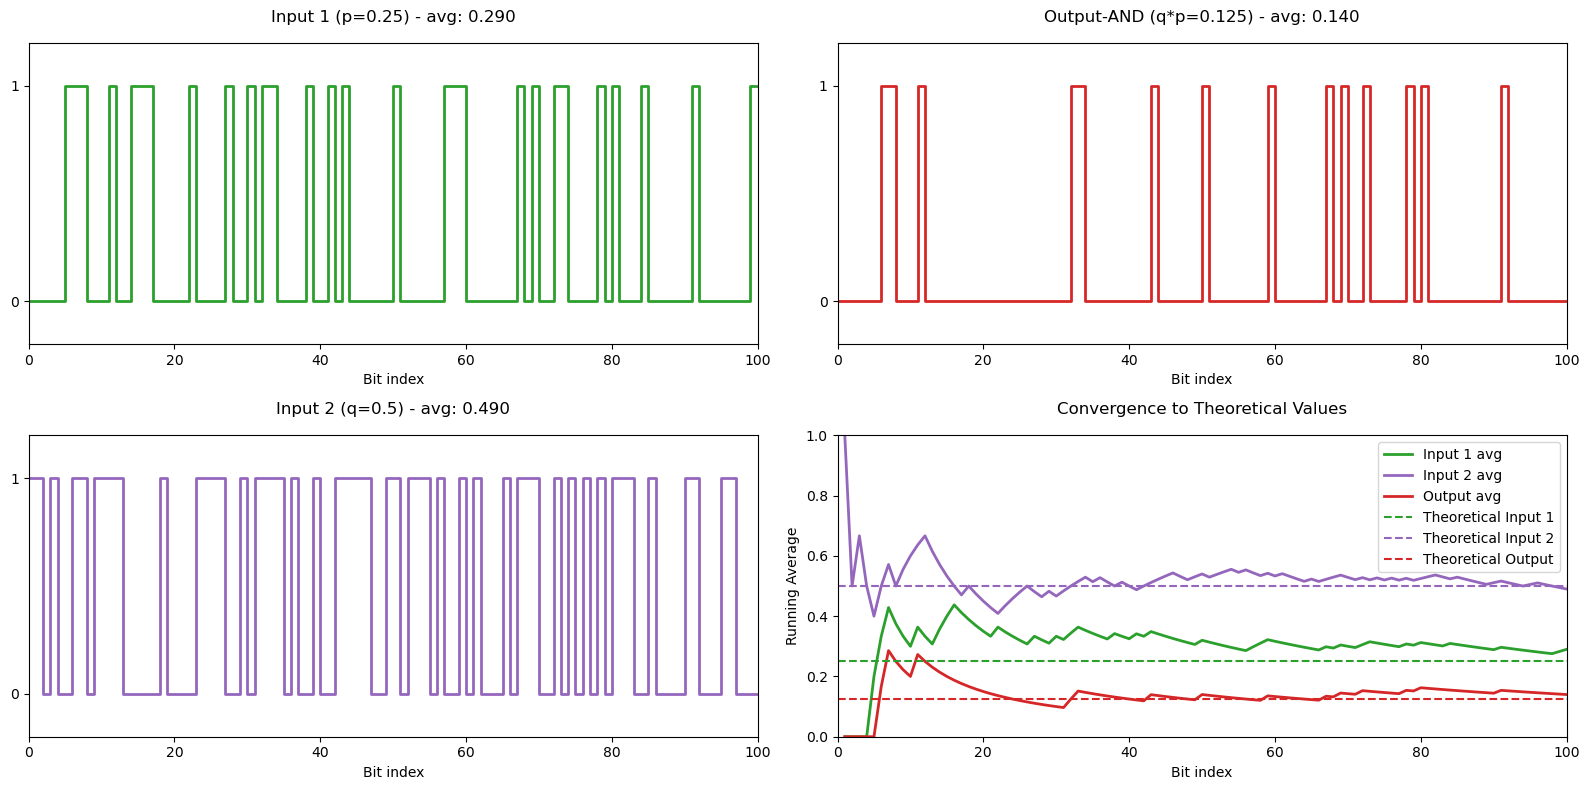

In [40]:
animate_stochastic_multiplication(0.25, 0.5, 100, seed=42, method='random', filename='stochastic_multiplication0.gif')

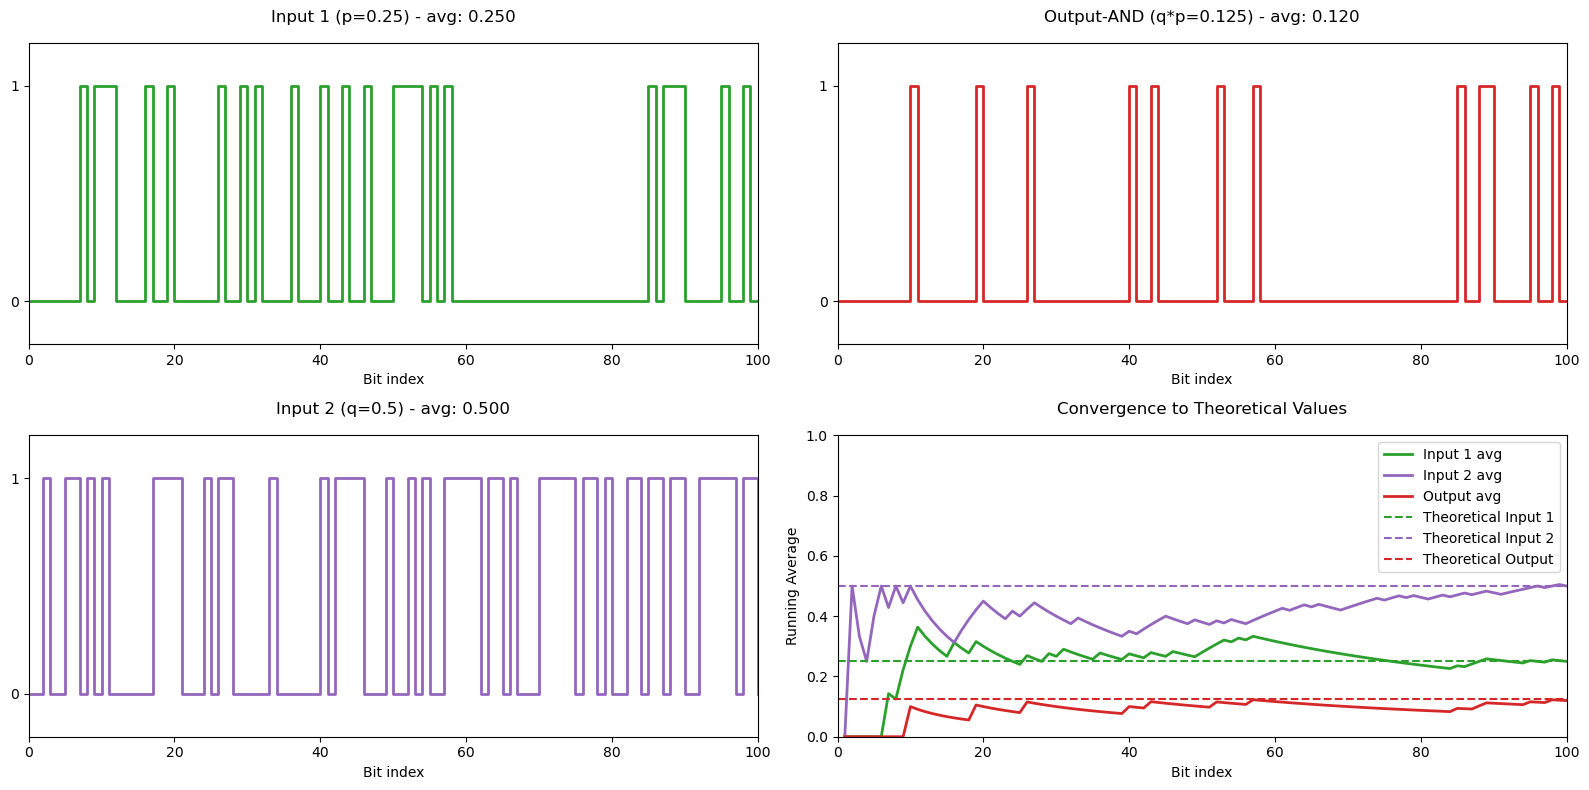

In [41]:
animate_stochastic_multiplication(0.25, 0.5, 100, seed=42, method='pseudo_random', filename='stochastic_multiplication1.gif')

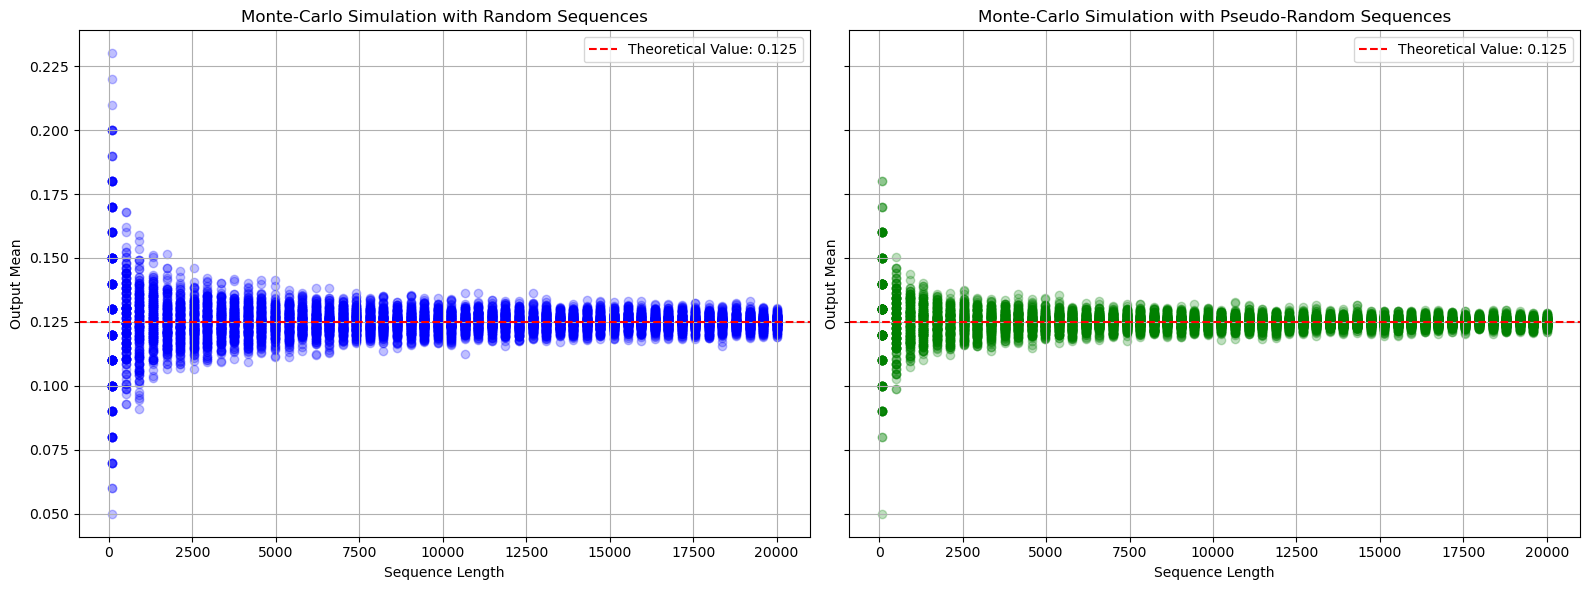

In [46]:
# Run the Monte-Carlo simulation
monte_carlo_stochastic_multiplication(p, q)